In [1]:
import sys, os
sys.path.insert(0, '../')
sys.path.insert(0, '../python_src/')

import numpy as np
import scipy as sp
import numpy.random as rand
import numpy.linalg as la
import gzip
import cPickle as pickle
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import collections as mc

import mech_network_solver as mns
import network
import tuning_algs as talgs
import network_plot as nplot

Loading Mechanical Network Deformation Solver Module


In [103]:
DIM = 2

NN = 512
Lp = -1.0
irec = 1
eta = 1.0

NDISC = 1.0

rand.seed(irec)

nw_label = "network_periodic_jammed/network_N{:05d}_Lp{:.2f}/network_irec{:04d}".format(NN, Lp, irec)

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 


NF = 1


edgei = net.edgei
edgej = net.edgej


inodesi = [[] for t in range(NF)]
inodesj = [[] for t in range(NF)]
istrain_bonds = [[] for t in range(NF)]

onodesi = [[] for t in range(NF)]
onodesj = [[] for t in range(NF)]
ostrain_bonds = [[] for t in range(NF)]

edge_set = set()



##################################################

L = np.copy(net.L)

pos = np.array([0.5*L[0], 0.5*L[1]])
s = network.closestEdge(net, pos)[0]


inodesi[0].append(edgei[s])
inodesj[0].append(edgej[s])
istrain_bonds[0].append(s)

NTS = 1

dtheta = 2*np.pi / 8

for i in range(NTS):
    pos = np.array([0.5, 0.5])
    pos += 0.4 * np.array([np.sin(i * dtheta), np.cos(i * dtheta)])
    pos *= L

    t1 = network.closestEdge(net, pos)[0]
    onodesi[0].append(edgei[t1])
    onodesj[0].append(edgej[t1])
    ostrain_bonds[0].append(t1)


######################################################

isvec = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(inodesi[t], inodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        isvec[t].extend(bvec) 

istrain = [[] for t in range(NF)]
istrain[0].append(1.0)


osvec = [[] for t in range(NF)]
ostrain = [[] for t in range(NF)]
for t in range(NF):
    for (i, j) in zip(onodesi[t], onodesj[t]):
        posi = net.node_pos[DIM*i:DIM*i+DIM]
        posj = net.node_pos[DIM*j:DIM*j+DIM]
        bvec = posj - posi
        bvec -= np.round(bvec/net.L)*net.L
        osvec[t].extend(bvec) 


        ostrain[t].append(eta)

pert = []
meas = []
for t in range(NF):
    pert.append(talgs.Perturb())
    pert[t].setInputStrain(len(inodesi[t]), inodesi[t], inodesj[t], istrain_bonds[t], istrain[t], isvec[t])

    meas.append(talgs.Measure())
    meas[t].setOutputStrain(len(onodesi[t]), onodesi[t], onodesj[t], ostrain_bonds[t], osvec[t])

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                       relative=False)    


K_max = np.ones(net.NE, float) / net.eq_length

K_disc = np.ones(net.NE, float)


tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)

data = tuner.tune()

print data

data['network_label'] = nw_label
data['istrain_nodesi'] = inodesi
data['istrain_nodesj'] = inodesj
data['istrain'] = istrain
data['istrain_edges'] = istrain_bonds

data['ostrain_nodesi'] = onodesi
data['ostrain_nodesj'] = onodesj
data['delta_ostrain_target'] = ostrain
data['ostrain_edges'] = ostrain_bonds
tuner.solver.setIntStrengths(data['K'])
(disp, strain) = tuner.solver.solveDOF()
data['disp'] = disp[0]

Initial objective function: 0.5
Removing 0 / 1416.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 809}
0 Objective function: 0.496964685442 Change: -0.0030353145577 Percent: -0.607062911539 %
Removing 0 / 1415.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 826}
1 Objective function: 0.48892969918 Change: -0.00803498626185 Percent: -1.61681232032 %
Removing 0 / 1414.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 828}
2 Objective function: 0.46730518371 Change: -0.0216245154702 Percent: -4.42282714805 %
Removing 2 / 1413.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 810}
3 Objective function: 0.447863455435 Change: -0.0194417282751 Percent: -4.16039217044 %
Removing 2 / 1412.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 798}
4 Objective function: 0.423974082088 Change: -0.023889373347 Percent: -5.33407516445 %
Removing 2 / 1411.0 / 1416 bonds would create zero modes...
{'disc': 0.0, 'bond': 711}
5 Objec

In [104]:
#Set initial response ratio

obj_func = mns.CyIneqRatioChangeObjFunc(len(np.concatenate(ostrain)), net.NE, 
                                        np.zeros(len(np.concatenate(ostrain)), float), np.concatenate(ostrain),
                                       relative=False)    



tuner = talgs.TuneDiscLin(net, pert, meas, obj_func, K_max, K_disc, NDISC=NDISC)
  
tuner.solver.setIntStrengths(K_max * K_disc)
meas_init = tuner.solver.solveMeas()

print meas_init

obj_func.setRatioInit(meas_init)

move_list = []
for b in range(net.NE):
    if data['K_disc'][b] == 0.0:
        move_list.append({'bond': b, 'disc': 1.0})
    else:
        move_list.append({'bond': b, 'disc': 0.0})
        
up_list = []
for move in move_list:
    up = talgs.Update()
    up.setStretchMod(1, [move['bond']], [K_max[move['bond']] * move['disc'] / NDISC])
    up_list.append(up.getCyUpdate())

    
tuner.solver.setIntStrengths(K_max * data['K_disc'])

meas_final = tuner.solver.solveMeas()
print meas_final

tuner.solver.prepareUpdateList(up_list)

zm_edges = []
cviol_edges = []
cviol_obj = np.zeros(net.NE, float)


for i, move in enumerate(move_list):     
                    
        bond = move['bond']
        disc = move['disc']

        bi = net.edgei[bond]
        bj = net.edgej[bond]

        (condition, m) = tuner.solver.solveMeasUpdate(i)
        
        if condition < 0.0:
            zm_edges.append(bond)                 
        else:
            obj = tuner.obj_func.objFunc(np.concatenate(m))
            if obj > 0.0:
                cviol_edges.append(bond)
                cviol_obj[bond] = obj

                
print zm_edges
print cviol_edges

[ 0.00081723]
[ 1.12366762]
[558, 803, 819, 820, 821, 825, 827, 829]
[514, 523, 561, 679, 680, 682, 687, 701, 708, 709, 711, 718, 724, 736, 737, 767, 790, 794, 798, 802, 809, 810, 813, 826, 828]


0.0 0.55333302083


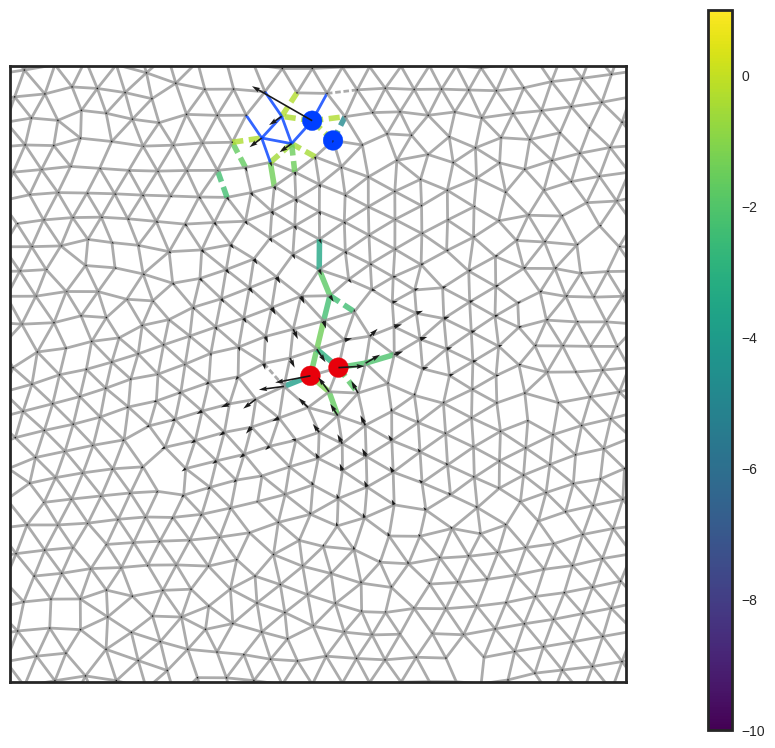

In [105]:
mpl.rcParams['mathtext.fontset'] = 'cm'
sns.set_context('poster', font_scale=1.25)
# sns.set_color_codes(palette='deep')
sns.set(color_codes=True, palette='bright')
# sns.set_palette("muted", 8)
sns.set_style('ticks', {'xtick.direction': 'in','ytick.direction': 'in', 'axes.linewidth': 2.0})

fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(1, 1, 1, aspect=1.0)

nw_label = data['network_label']
inodesi = data['istrain_nodesi'][0]
inodesj = data['istrain_nodesj'][0]
onodesi = data['ostrain_nodesi'][0]
onodesj = data['ostrain_nodesj'][0]
ostrain_edges = data['ostrain_edges'][0]

removed = np.where(data['K_disc'] == 0.0)[0]
disp = data['disp']

with open("/data1/home/rocks/data/{:}.pkl".format(nw_label), 'rb') as pkl_file:

    nw_data = pickle.load(pkl_file)
    net = nw_data['network'] 

    

styles = {edge: {} for edge in range(net.NE)}
for edge in removed:
    styles[edge]['ls'] = (0.0, (2.0,1.0))

for edge in zm_edges:
    styles[edge]['color'] = 'b'

print np.min(cviol_obj), np.max(cviol_obj)
    
norm = mcolors.Normalize(vmin=-10, vmax=1.0)
cmap = mpl.cm.viridis
smap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

    
for edge in cviol_edges:
    styles[edge]['lw'] = 4.0
    styles[edge]['color'] = smap.to_rgba(np.log10(cviol_obj[edge]))
#     styles[edge]['color'] = 'r'
    
nplot.show_network(ax1, net, styles=styles)

styles = {}
for i in inodesi:
    styles[i] = {}
    styles[i]['color'] = 'r'
for i in inodesj:
    styles[i] = {}
    styles[i]['color'] = 'r'
    
for i in onodesi:
    styles[i] = {}
    styles[i]['color'] = 'b'
for i in onodesj:
    styles[i] = {}
    styles[i]['color'] = 'b'

nplot.show_nodes(ax1, net, styles.keys(), styles=styles)
nplot.show_vecs(ax1, net, disp)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

cax = fig.add_axes([1.0, 0.05, 0.03, 0.90])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical')
# cbar.set_label(r'$\Delta \eta / \eta_0$')
# cbar.ax.tick_params(labelsize=20)

plt.show()

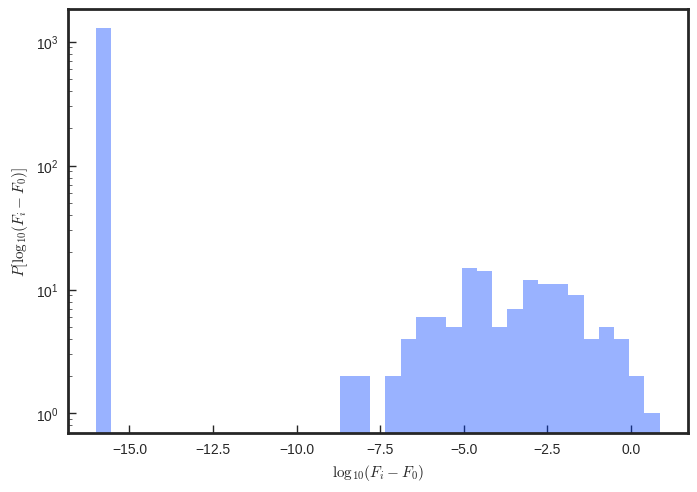

In [74]:
fig, ax = plt.subplots(1,1)
sns.distplot(np.log10(cviol_obj+1e-16), kde=False, ax=ax)

ax.set_yscale('log')

ax.set_ylabel(r'$P[\log_{10}(F_i - F_0)]$')
ax.set_xlabel(r'$\log_{10}(F_i - F_0)$')

plt.show()